In [1]:
# %% [markdown]
# # Predicción de Series Temporales con AutoGluon
# 
# Este notebook demuestra cómo usar AutoGluon para predecir series temporales.
# Predeciremos 2 períodos hacia adelante desde el último punto de entrenamiento.

# %% [markdown]
# ## 1. Instalación e Importación de Librerías

# %%
# Instalar AutoGluon (ejecutar solo si no está instalado)
# !pip install autogluon.timeseries

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


In [2]:

# %% [markdown]
# ## 2. Creación de Datos de Ejemplo
# 
# Crearemos una serie temporal sintética con tendencia y estacionalidad

# %%
# Generar datos sintéticos
np.random.seed(42)
dates = pd.date_range('2020-01-01', '2023-12-31', freq='D')
n_points = len(dates)

# Crear una serie con tendencia, estacionalidad y ruido
trend = np.linspace(100, 200, n_points)
seasonality = 20 * np.sin(2 * np.pi * np.arange(n_points) / 365.25)
noise = np.random.normal(0, 5, n_points)
values = trend + seasonality + noise

# Crear DataFrame
df = pd.DataFrame({
    'timestamp': dates,
    'target': values,
    'item_id': 'serie_1'
})

print(f"Datos creados: {len(df)} puntos desde {df['timestamp'].min()} hasta {df['timestamp'].max()}")
df.head()


Datos creados: 1461 puntos desde 2020-01-01 00:00:00 hasta 2023-12-31 00:00:00


,timestamp,target,item_id
0,2020-01-01,102.483571,serie_1
1,2020-01-02,99.721203,serie_1
2,2020-01-03,104.063390,serie_1
3,2020-01-04,108.852316,serie_1
4,2020-01-05,100.478314,serie_1


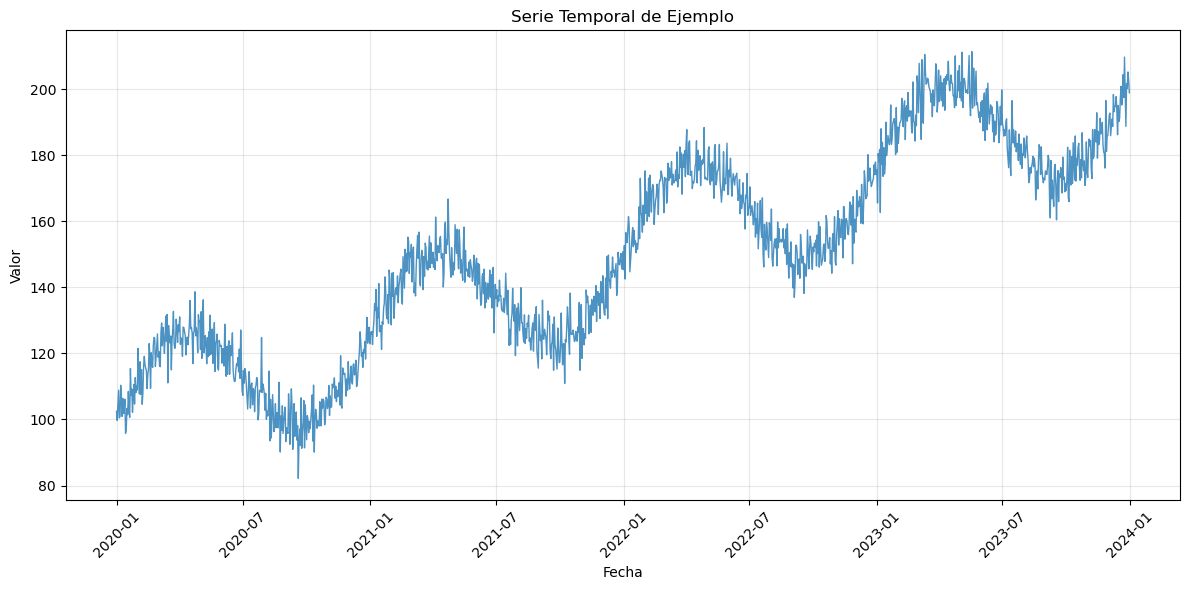

In [3]:

# %% [markdown]
# ## 3. Visualización de los Datos

# %%
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['target'], linewidth=1, alpha=0.8)
plt.title('Serie Temporal de Ejemplo')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:

# %% [markdown]
# ## 4. Preparación de Datos para AutoGluon
# 
# AutoGluon requiere un formato específico: TimeSeriesDataFrame

# %%
# Dividir los datos en entrenamiento y test
# Reservamos los últimos 30 días para validación
split_date = df['timestamp'].max() - pd.Timedelta(days=30)
train_df = df[df['timestamp'] <= split_date].copy()
test_df = df[df['timestamp'] > split_date].copy()

print(f"Datos de entrenamiento: {len(train_df)} puntos")
print(f"Datos de test: {len(test_df)} puntos")
print(f"Último punto de entrenamiento: {train_df['timestamp'].max()}")

# %%
# Crear TimeSeriesDataFrame para AutoGluon
train_data = TimeSeriesDataFrame.from_data_frame(
    train_df,
    id_column='item_id',
    timestamp_column='timestamp'
)

print("Estructura de datos para AutoGluon:")
print(train_data)


Datos de entrenamiento: 1431 puntos
Datos de test: 30 puntos
Último punto de entrenamiento: 2023-12-01 00:00:00
Estructura de datos para AutoGluon:
                        target
item_id timestamp             
serie_1 2020-01-01  102.483571
        2020-01-02   99.721203
        2020-01-03  104.063390
        2020-01-04  108.852316
        2020-01-05  100.478314
...                        ...
        2023-11-27  196.625030
        2023-11-28  181.181657
        2023-11-29  185.948404
        2023-11-30  186.030760
        2023-12-01  189.315110

[1431 rows x 1 columns]


In [5]:

# %% [markdown]
# ## 5. Entrenamiento del Modelo AutoGluon

# %%
# Configurar el predictor
predictor = TimeSeriesPredictor(
    prediction_length=2,  # Predecir 2 períodos hacia adelante
    target='target',
    eval_metric='MAPE',
    verbosity=2
)

# Entrenar el modelo
print("Iniciando entrenamiento...")
predictor.fit(
    train_data=train_data,
    time_limit=300,  # 5 minutos máximo
    presets='medium_quality'  # Opciones: 'fast_training', 'good_quality', 'high_quality'
)


Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to '/Users/pablocablinski/Documents/GitHub/MCD-Fundamentos/AutogluonModels/ag-20250605_031519'


Iniciando entrenamiento...


=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 22.6.0: Thu Apr 24 20:25:14 PDT 2025; root:xnu-8796.141.3.712.2~1/RELEASE_X86_64
CPU Count:          4
GPU Count:          0
Memory Avail:       1.70 GB / 8.00 GB (21.3%)
Disk Space Avail:   125.37 GB / 233.47 GB (53.7%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 300,
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 1431 rows, 1 time series. Median time series length is 1431 (min=1431, 

In [6]:

# %% [markdown]
# ## 6. Realizar Predicciones

# %%
# Hacer predicciones para 2 períodos adelante
predictions = predictor.predict(train_data)
print("Predicciones generadas:")
print(predictions)

# %%
# Obtener las fechas de predicción
last_train_date = train_df['timestamp'].max()
prediction_dates = [
    last_train_date + pd.Timedelta(days=1),
    last_train_date + pd.Timedelta(days=2)
]

print(f"Último día de entrenamiento: {last_train_date}")
print(f"Predicciones para: {prediction_dates}")


Model not specified in predict, will default to the model with the best validation score: ETS


Predicciones generadas:
                          mean         0.1         0.2         0.3  \
item_id timestamp                                                    
serie_1 2023-12-02  187.733438  181.068745  183.356598  185.006300   
        2023-12-03  187.963701  181.276801  183.572276  185.227476   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
serie_1 2023-12-02  186.415910  187.733438  189.050967  190.460577   
        2023-12-03  186.641782  187.963701  189.285620  190.699927   

                           0.8         0.9  
item_id timestamp                           
serie_1 2023-12-02  192.110279  194.398131  
        2023-12-03  192.355126  194.650602  
Último día de entrenamiento: 2023-12-01 00:00:00
Predicciones para: [Timestamp('2023-12-02 00:00:00'), Timestamp('2023-12-03 00:00:00')]


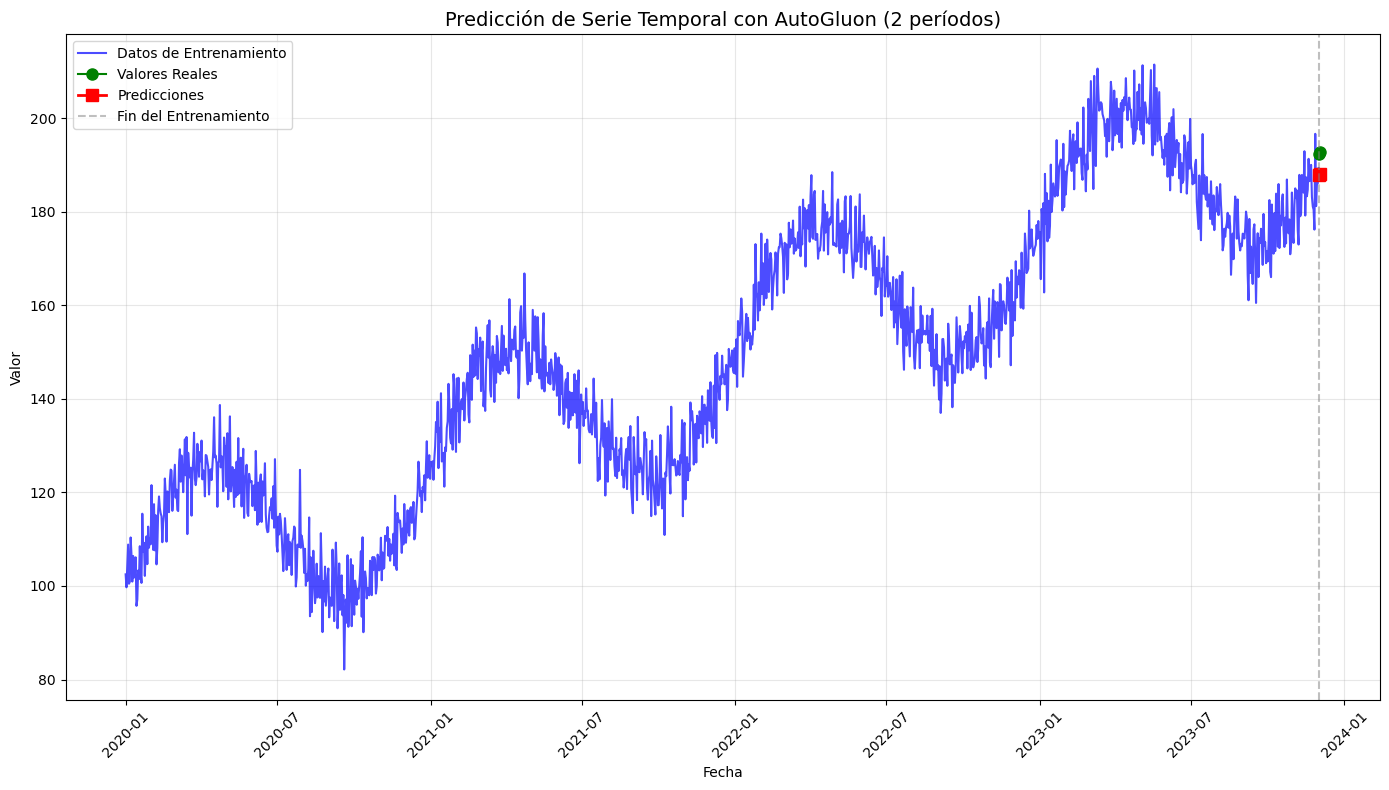

In [7]:

# %% [markdown]
# ## 7. Visualización de Resultados

# %%
# Preparar datos para visualización
fig, ax = plt.subplots(figsize=(14, 8))

# Datos de entrenamiento
ax.plot(train_df['timestamp'], train_df['target'], 
        label='Datos de Entrenamiento', color='blue', alpha=0.7)

# Datos reales de test (para comparación)
ax.plot(test_df['timestamp'][:2], test_df['target'][:2], 
        label='Valores Reales', color='green', marker='o', markersize=8)

# Predicciones
pred_values = predictions.loc['serie_1', 'mean'].values
ax.plot(prediction_dates, pred_values, 
        label='Predicciones', color='red', marker='s', markersize=8, linewidth=2)

# Resaltar la zona de predicción
ax.axvline(x=last_train_date, color='gray', linestyle='--', alpha=0.5, 
           label='Fin del Entrenamiento')

# Configuración del gráfico
ax.set_title('Predicción de Serie Temporal con AutoGluon (2 períodos)', fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:

# %% [markdown]
# ## 8. Evaluación de Resultados

# %%
# Comparar predicciones con valores reales
if len(test_df) >= 2:
    real_values = test_df['target'][:2].values
    pred_values = predictions.loc['serie_1', 'mean'].values
    
    print("=== COMPARACIÓN DE RESULTADOS ===")
    for i, (date, real, pred) in enumerate(zip(prediction_dates, real_values, pred_values)):
        error = abs(real - pred)
        error_pct = (error / abs(real)) * 100
        print(f"Día {i+1} ({date.strftime('%Y-%m-%d')}):")
        print(f"  Valor Real: {real:.2f}")
        print(f"  Predicción: {pred:.2f}")
        print(f"  Error Absoluto: {error:.2f}")
        print(f"  Error Porcentual: {error_pct:.2f}%")
        print()
    
    # Error promedio
    mae = np.mean(np.abs(real_values - pred_values))
    mape = np.mean(np.abs((real_values - pred_values) / real_values)) * 100
    print(f"Error Absoluto Medio (MAE): {mae:.2f}")
    print(f"Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%")


=== COMPARACIÓN DE RESULTADOS ===
Día 1 (2023-12-02):
  Valor Real: 192.22
  Predicción: 187.73
  Error Absoluto: 4.49
  Error Porcentual: 2.34%

Día 2 (2023-12-03):
  Valor Real: 192.82
  Predicción: 187.96
  Error Absoluto: 4.85
  Error Porcentual: 2.52%

Error Absoluto Medio (MAE): 4.67
Error Porcentual Absoluto Medio (MAPE): 2.43%


In [10]:

# %% [markdown]
# ## 9. Información del Modelo

# %%
# Obtener información sobre los modelos entrenados
leaderboard = predictor.leaderboard()
print("=== LEADERBOARD DE MODELOS ===")
print(leaderboard)

# %%
# Información adicional del mejor modelo
print("=== INFORMACIÓN DEL PREDICTOR ===")
print(f"Métrica de evaluación: {predictor.eval_metric}")
print(f"Longitud de predicción: {predictor.prediction_length}")
print(f"Columna objetivo: {predictor.target}")


=== LEADERBOARD DE MODELOS ===
              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -0.008134      25.230592           0.373089          7
1               ETS  -0.008134      25.230592           0.040416          5
2             Naive  -0.009113       6.874066           0.028646          1
3     DirectTabular  -0.013271       0.170985           1.738933          4
4             Theta  -0.017722       1.643195           0.036621          6
5  RecursiveTabular  -0.020121       0.061437           2.218420          3
6     SeasonalNaive  -0.029451       2.102342           0.037887          2
=== INFORMACIÓN DEL PREDICTOR ===
Métrica de evaluación: MAPE
Longitud de predicción: 2
Columna objetivo: target


In [ ]:

# %% [markdown]
# ## 10. Guardar y Cargar Modelo (Opcional)

# %%
# Guardar el modelo entrenado
# predictor.save('modelo_autogluon_ts')
# print("Modelo guardado exitosamente")

# Para cargar el modelo posteriormente:
# predictor_loaded = TimeSeriesPredictor.load('modelo_autogluon_ts')

# %% [markdown]
# ## Conclusiones
# 
# Este notebook demostró cómo:
# 1. Preparar datos para AutoGluon TimeSeries
# 2. Entrenar múltiples modelos automáticamente
# 3. Realizar predicciones para 2 períodos futuros
# 4. Evaluar la calidad de las predicciones
# 5. Visualizar los resultados
# 
# AutoGluon automáticamente probó varios algoritmos y seleccionó el mejor basado en la métrica MAPE.
# Los resultados muestran qué tan bien el modelo puede predecir los próximos 2 períodos.

# %%